# Assignment #4

### Creating a recommendation system for Netflix and organizing its audience into clusters.

### Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import functions
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from functions import min_hash_signatures, get_top5_movies, find_similar_users, recommend_movies

### Loading and investigating the data

In [2]:
df = pd.read_csv('netflix.csv')
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [4]:
df.describe()

,Unnamed: 0,duration
count,671736.00000,6.717360e+05
mean,394640.50000,3.347603e+04
std,193913.62455,1.574396e+05
min,58773.00000,-1.000000e+00
25%,226706.75000,0.000000e+00
50%,394640.50000,1.400000e+01
75%,562574.25000,6.672250e+03
max,730508.00000,1.823725e+07


In [5]:
df.shape

(671736, 8)

In [6]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [7]:
# check for missing values
df.isnull().sum()


Unnamed: 0      0
datetime        0
duration        0
title           0
genres          0
release_date    0
movie_id        0
user_id         0
dtype: int64

In [8]:
# check for duplicates
df.duplicated().sum()

0

### 1. Recommendation System

In [9]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [10]:
# eliminating the clicks with duration 0 as it means the user did not watch the movie and may be it was a miss click
df = df[df['duration'] != 0]
df.head(15)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"Drama, History, War",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"Drama, Horror, Thriller",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"Comedy, Drama",2000-04-14,584bffaf5f,759ae2eac9
13,58786,2017-01-01 21:33:26,38120.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,5b1727dc12
14,58787,2017-01-01 21:37:41,7799.0,Beasts of No Nation,"Drama, War",2015-10-16,c57e11da52,3142b4c730
17,58790,2017-01-01 22:52:08,181.0,Maravilla,"Documentary, Biography, Sport",2014-05-29,19c537b01e,93e9369e81
19,58792,2017-01-01 00:19:40,54195.0,About Last Night,"Comedy, Romance",2014-02-14,f7d088d208,78cdb81c4f
20,58793,2017-01-01 00:49:03,44413.0,Fight Club,Drama,1999-10-15,338abadc17,ac30a85c52


In [11]:
# counting the number of clicks for each movie
number_of_clicks = df['title'].value_counts()
# top 10 movies clicked
top_10_clicked = number_of_clicks[:10]
top_10_clicked

title
Black Mirror: Bandersnatch                      2884
Bright                                          1928
Avengers: Age of Ultron                         1561
Annihilation                                    1536
Bird Box                                        1474
Deadpool                                        1425
Hot Fuzz                                        1368
The Hitman's Bodyguard                          1307
FYRE: The Greatest Party That Never Happened    1203
Captain America: Civil War                      1153
Name: count, dtype: int64

In [12]:
top_10_clicked.index

Index(['Black Mirror: Bandersnatch', 'Bright', 'Avengers: Age of Ultron',
       'Annihilation', 'Bird Box', 'Deadpool', 'Hot Fuzz',
       'The Hitman's Bodyguard',
       'FYRE: The Greatest Party That Never Happened',
       'Captain America: Civil War'],
      dtype='object', name='title')

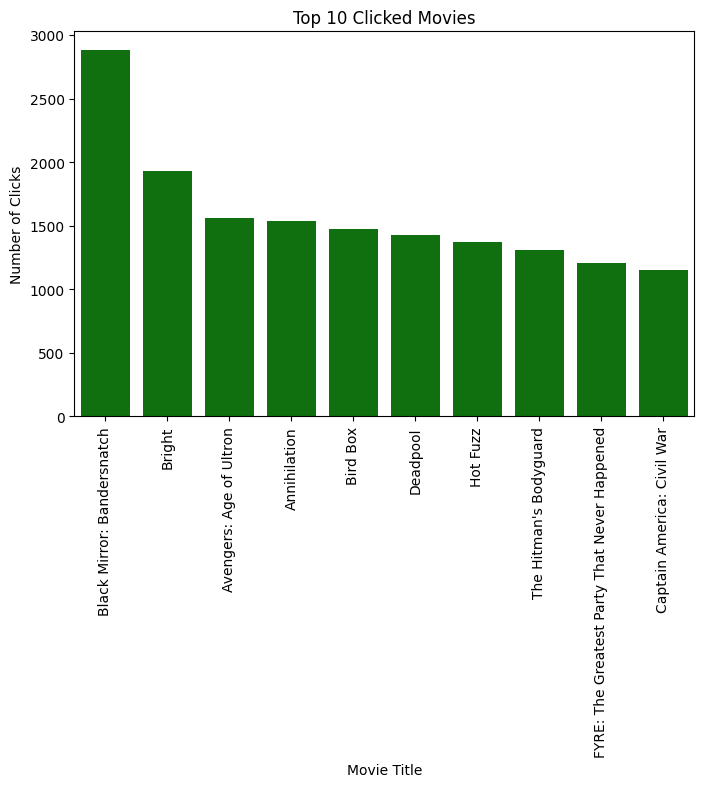

In [13]:
# plotting the top 10 clicked movies
plt.figure(figsize=(8, 5))
sns.barplot(x=top_10_clicked.index, y=top_10_clicked.values, color='green')
plt.title('Top 10 Clicked Movies')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Clicks')
plt.show()


In [14]:
top_10_movies_titles_genres = df[df['title'].isin(top_10_clicked.index)][['title', 'movie_id','genres']]
top_10_movies_titles_genres.drop_duplicates(inplace=True)
top_10_movies_titles_genres = top_10_movies_titles_genres[top_10_movies_titles_genres['genres'] != 'NOT AVAILABLE']

# top 10 clicked movies and their genres
top_10_movies_titles_genres


,title,movie_id,genres
757,Captain America: Civil War,572b55789d,"Action, Adventure, Sci-Fi"
22312,Deadpool,2b83f89fbe,"Action, Adventure, Comedy, Sci-Fi"
38370,Avengers: Age of Ultron,51a1a42126,"Action, Adventure, Sci-Fi"
69379,Hot Fuzz,6467fee6b6,"Action, Comedy, Mystery, Thriller"
221353,Bright,0ca8bc0382,"Action, Fantasy, Thriller"
306179,Annihilation,1f579d43c3,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr..."
323723,The Hitman's Bodyguard,261df73aa6,"Action, Comedy, Crime, Thriller"
508195,Bird Box,b4a3d3b288,"Drama, Horror, Sci-Fi"
514702,Black Mirror: Bandersnatch,e847f14da5,"Drama, Mystery, Sci-Fi, Thriller"
538537,FYRE: The Greatest Party That Never Happened,3a84965f36,"Documentary, Music"


### 1.2 Minhash Signatures

For the hashing process, the uniques genres will be extracted from the "genres" column which will be used as **shinglings**. After that, the users will be aggregated in the same bucket if they have **similar** genres of interest.

In [15]:
# Preprocess genres column
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

# Create a set of unique genres
genres_list = list(set(genre for genres in df['genres'] for genre in genres))


In [16]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [17]:
print('There are',len(genres_list), 'unique genres in the dataset, which are', genres_list)

There are 27 unique genres in the dataset, which are ['Animation', 'Film-Noir', 'Music', 'Sport', 'Mystery', 'NOT AVAILABLE', 'Family', 'Musical', 'Biography', 'Horror', 'Comedy', 'News', 'Crime', 'Adventure', 'Sci-Fi', 'War', 'Talk-Show', 'Short', 'Drama', 'Thriller', 'Romance', 'Action', 'Documentary', 'Fantasy', 'Reality-TV', 'History', 'Western']


In [18]:
# unique user_ids
unique_users = list(df['user_id'].unique())

# Create a binary matrix where each row represents a user, and each column represents a genre
binary_matrix = pd.DataFrame(0, index=genres_list, columns=unique_users)




In [19]:
binary_matrix.shape

(27, 120271)

In [20]:
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Animation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Film-Noir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mystery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']
    
    # Check if each genre is in the binary_matrix columns
    for genre in genres:
        if genre in binary_matrix.index:
            # Update the corresponding entry to 1
            binary_matrix.loc[genre, user_id] = 1


In [22]:
# Drop the NOT AVAILABLE column
binary_matrix.drop('NOT AVAILABLE', axis=0, inplace=True)
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Animation,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
Film-Noir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Sport,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
Mystery,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [23]:
binary_matrix.shape

(26, 120271)

In [24]:
np.random.seed(42)  

# number of permutations
perms = len(genres_list)
# number of buckets
num_buckets = 1000
# Convert the binary matrix to a NumPy array
binary_matrix = binary_matrix.to_numpy()

signatures, buckets = min_hash_signatures(binary_matrix, perms, num_buckets)


### 1.3 Locality-Sensitive Hashing (LSH)

In [25]:
# Example usage
target_user_id = "8e1be40e32"  
most_similar_users = find_similar_users(target_user_id, unique_users, signatures)

print(f"The two most similar users to the user with ID:{target_user_id} are:")
for user_id, similarity in most_similar_users:
    print(f"User ID: {user_id}, Similarity: {similarity}")

The two most similar users to the user with ID:8e1be40e32 are:
User ID: da3f0669d2, Similarity: 0.9878400682662835
User ID: 3983837e59, Similarity: 0.9860299350529271


In [26]:
user_A_movies = get_top5_movies(most_similar_users[0][0], df, 'A')
user_B_movies = get_top5_movies(most_similar_users[1][0], df, 'B')

In [27]:
user_A_movies

,title,movie_id,clicks,user
0,Brain on Fire,7fa4b44faf,3,A
1,Loving Vincent,c8677345e4,2,A
2,Angela's Ashes,1218186787,2,A
3,Moonstruck,3af7570904,2,A
4,Feminists: What Were They Thinking?,924c8b4002,2,A


In [28]:
user_B_movies

,title,movie_id,clicks,user
0,Good Will Hunting,196b10fbd4,3,B
1,The Bank Job,fb219cc6c9,2,B
2,Security,b5f025e63d,1,B
3,Unlocked,a9954fc307,1,B
4,Churchill,645ae57fc7,1,B


In [29]:
movies_to_recommend = recommend_movies(user_A_movies, user_B_movies)
print('The recommended movies are:')
for movie in movies_to_recommend:
    print(movie)

The recommended movies are:
Brain on Fire
Loving Vincent
Angela's Ashes
Moonstruck
Feminists: What Were They Thinking?


## Approach:

### Step 1: Min-Hash Signature Calculation

#### Function: `min_hash_signature(matrix, num_hashes)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.

- **Output:**
  - Min-hash signatures for each user.

- **Explanation:**
  1. For each genre, iterate through users and update the min-hash signature.
  2. Generate random hash functions to create permutations of user indices.
  3. Calculate the min-hash signature for each user by considering their liked genres.
  4. The resulting matrix (`signature_matrix`) contains min-hash signatures for all users.

### Step 2: Bucketing Users Using LSH

#### Function: `min_hash_signatures(matrix, num_hashes, num_buckets)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.
  - Number of buckets `num_buckets`.

- **Output:**
  - Min-hash signatures for each user.
  - Users grouped into buckets.

- **Explanation:**
  1. Extend the previous function to include bucketing logic.
  2. Initialize an empty dictionary (`buckets`) to store user indices for each bucket.
  3. For each genre:
     - Update min-hash signatures for users.
     - Map the min-hash signature to a bucket using a hash function.
     - Add the user to the corresponding bucket in the `buckets` dictionary.


### 3. Bonus: Clustering the users using DBSCAN algorithm

In [30]:
# Step 1: Preprocess the genres column using one-hot encoding

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)

# Step 2: Combine the one-hot encoded genres with other relevant columns
processed_data = pd.concat([df[['user_id', 'duration']], genres_encoded], axis=1)

# Step 3: Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(processed_data.drop('user_id', axis=1))  # Drop user_id for clustering

# Step 4: Apply DBSCAN
eps = 0.5  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 5  # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Step 5: Add the cluster labels to the original DataFrame
df['cluster'] = labels

# Display the clusters
df.head()


,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,cluster
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,0
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,1
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32,2
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a,3
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9,4


In [34]:
number_of_clusters = len(df['cluster'].unique()) 
print('The data was clustered into', number_of_clusters, 'clusters.')

The data was clustered into 971 clusters.


### Comment

The users in the dataset were clustered using the DBSCAN algorithm into 971 clusters which  makes since the users were clustered into 1000 buckets in the LSH algorithm.